In [1]:
import os, tempfile
gdal_data_path = 'C:/ProgramData/miniconda3/envs/GIStools/Library/share/gdal'
os.environ['GDAL_DATA'] = gdal_data_path
from osgeo import  gdal, ogr, gdal_array 
gdal.UseExceptions()
gdal.AllRegister()

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd # handling large data as table sheets
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from osgeo import gdal, ogr
import numpy as np
from osgeo import gdal, ogr
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

#import all functions from Mask_Raster_by_Shapefile_Bounds
from Mask_Raster_by_Shapefile_Bounds import get_layer_extent

from rasterio.mask import mask
from rasterio.windows import from_bounds



In [2]:


def clip_raster_by_bounds(input_raster_path, output_folder, template_bounds):
    """
    Clip a raster file to the specified bounds.

    :param input_raster_path: Path to the input raster file.
    :param output_raster_path: Path to the output clipped raster file.
    :param bounds: A tuple of (min_x, min_y, max_x, max_y) representing the bounding box.
    """
    output_path = os.path.join(output_folder, 'Clipped_Raster.tif')
    with rasterio.open(input_raster_path) as input_raster:
        
        window = from_bounds(*template_bounds, input_raster.transform)
        # Read the data from this window
        clipped_array = input_raster.read(window=window)

        # Check if the clipped array has an extra dimension and remove it if present
        if clipped_array.ndim == 3 and clipped_array.shape[0] == 1:
            clipped_array = clipped_array.squeeze()

        # Update metadata for the clipped raster
        out_meta = input_raster.meta.copy()
        out_meta.update({
            "height": clipped_array.shape[0],
            "width": clipped_array.shape[1],
            "transform": rasterio.windows.transform(window, input_raster.transform)
        })

        # Generate the output path

        # Save the clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(clipped_array, 1)

        return output_path

def extract_image_data(raster_path, results_txt):
    print('Extracting image data from: {}'.format(raster_path))
    raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

    temp_file = tempfile.NamedTemporaryFile(delete=False)
    filename = temp_file.name
    temp_file.close()  # Close the file so np.memmap can use it

    raster_3Darray = np.memmap(filename, dtype=gdal_array.GDALTypeCodeToNumericTypeCode(raster.GetRasterBand(1).DataType),
                mode='w+', shape=(raster.RasterYSize, raster.RasterXSize, raster.RasterCount))
    for b in range(raster_3Darray.shape[2]):
        raster_3Darray[:, :, b] = raster.GetRasterBand(b + 1).ReadAsArray()

    row = raster.RasterYSize
    col = raster.RasterXSize
    band_number = raster.RasterCount

    print('Image extent: {} x {} (row x col)'.format(row, col))
    print('Number of Bands: {}'.format(band_number))
    print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))
    print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))

    return raster, raster_3Darray

def burn_shapefile_into_raster(shapefile, raster, output_folder, raster_3Darray, results_txt, attribute):
    # Open the reference raster
    output_raster_path = os.path.join(output_folder, 'Rasterized_Validation.tif')
    
    shape_dataset = ogr.Open(shapefile)
    shape_layer = shape_dataset.GetLayer()

    mem_drv = gdal.GetDriverByName('MEM')
    mem_raster = mem_drv.Create('', raster.RasterXSize, raster.RasterYSize, 1, gdal.GDT_UInt16)
    mem_raster.SetProjection(raster.GetProjection())
    mem_raster.SetGeoTransform(raster.GetGeoTransform())
    mem_band = mem_raster.GetRasterBand(1)
    mem_band.Fill(0)
    mem_band.SetNoDataValue(0)

    att_ = 'ATTRIBUTE=' + attribute
    err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1], [att_, "ALL_TOUCHED=TRUE"])
    assert err == gdal.CE_None

    roi = mem_raster.ReadAsArray()
    try:
        X = raster_array[roi > 0, :]
    except IndexError:
        X = raster_array[roi > 0]
    y = roi[roi > 0]
    n_samples = (roi > 0).sum()
    labels = np.unique(roi[roi > 0])
    
    
    #Save the rasterized validation shapefile
    gdal.Warp(output_raster_path, mem_raster, format='GTiff')
    
    
    with open(results_txt, "a") as file:
        print('------------------------------------', file=file)
        print('VALIDATION', file=file)
        
        print('{n} validation pixels'.format(n=n_samples), file=file)
        print('validation data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=file)
                
    return output_raster_path


def compute_confusion_matrix(target_raster, classified_raster, results_txt, plot = False):
    """
    Compute a confusion matrix and print it to a text file.

    Args:
        target_raster (str): Filepath to the rasterized validation shapefile. Should contain labels that correspond to the classified raster.
        classified_raster (str): Filepath to the classified raster
        results_txt (str): Filepath to the text file to print the confusion matrix to. 

    Returns:
        pandas.core.frame.DataFrame: Confusion matrix as a pandas dataframe.
    """
    
    #Print input parameters to txt file
    print('Reference raster: {}'.format(classified_raster), file=open(results_txt, "a"))
    print('Target raster: {}'.format(target_raster), file=open(results_txt, "a"))
    #Print a new line that labels the start of the confusion matrix
    print('----------Confusion Matrix:----------------', file=open(results_txt, "a"))
    
    # Open the reference raster for reading
    ref_ds = gdal.Open(classified_raster, gdal.GA_ReadOnly)
    ref_img = ref_ds.ReadAsArray()

    # Open the target raster for validation
    target_ds = gdal.Open(target_raster, gdal.GA_ReadOnly)
    val_img = target_ds.ReadAsArray()

    # Find the number of validation pixels
    n_val = (val_img > 0).sum()
    print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))

    # Find the unique labels in the validation dataset
    labels_v = np.unique(val_img[val_img > 0])
    print('Validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))

    # Subset the classification image (ref_img) with the validation image (val_img)
    X_v = ref_img[val_img > 0]
    y_v = val_img[val_img > 0]
    #drop all 0 values from the classification and validation arrays

    X_v = np.insert(X_v, 0, 0)
    y_v = np.insert(y_v, 0, 0)
    # Print matrix sizes
    print('Our X matrix is sized: {sz}'.format(sz=X_v.shape), file=open(results_txt, "a"))
    print('Our y array is sized: {sz}'.format(sz=y_v.shape), file=open(results_txt, "a"))

    # Compute the confusion matrix
    convolution_mat = pd.crosstab(y_v, X_v, margins=True)
    #Drop the last row and column of the confusion matrix
    convolution_mat = convolution_mat.drop(convolution_mat.index[-1])
    convolution_mat = convolution_mat.drop(convolution_mat.columns[-1], axis=1)
    #Drop first row and column of the confusion matrix
    convolution_mat = convolution_mat.drop(convolution_mat.index[0])
    convolution_mat = convolution_mat.drop(convolution_mat.columns[0], axis=1)
    print(convolution_mat, file=open(results_txt, "a"))

    # Compute classification metrics
    target_names = [str(i) for i in range(0, labels_v.size + 1)]
    target_names = ['Uncl.', 'Veg', 'Log', 'Burn_Log', 'BE', 'Water']
    #print unique values in x and y
    print('Unique values in X: {}'.format(np.unique(X_v)))
    print('Unique values in y: {}'.format(np.unique(y_v)))
    sum_mat = classification_report(y_v, X_v, target_names=target_names)
    #Drop first row of the sum matrix string
    sum_mat = sum_mat.split('\n', 1)[1]
    target_names = ['Vegetation', 'Log', 'Burned Log', 'Bare Earth', 'Water']
    print(sum_mat, file=open(results_txt, "a"))

    # Compute Overall Accuracy
    oaa = accuracy_score(y_v, X_v) * 100
    print('OAA = {} %'.format(oaa), file=open(results_txt, "a"))

    if plot:
        # Plotting the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(convolution_mat, annot=True, fmt='d', cmap='inferno')
        plt.title('Confusion Matrix Heatmap')
        #add category labels to the heatmap and shift the labels to the center of the cell
        plt.xticks(np.arange(len(target_names)) + 0.5, target_names)
        plt.yticks(np.arange(len(target_names)) + 0.5, target_names, rotation=0)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    return convolution_mat, sum_mat, oaa

def combine_classes(input_raster, output_raster = None, class_to_dissolve = 5, class_to_keep = 4):
    # Open the input raster file
    with rasterio.open(input_raster) as src:
        # Read the data from the first band
        data = src.read(1)
        
        # Modify the data by setting values equal to 5 to 4
        data[data == class_to_dissolve] = class_to_keep
        data[data == 6] = 5
        # Copy the metadata from the source raster
        meta = src.meta.copy()
        
        # Create the output raster file
        with rasterio.open(output_raster, 'w', **meta) as dst:
            # Write the modified data to the output raster
            dst.write(data, 1)
    return output_raster

def parse_classification_report(classification_summary):
    # Split the summary string into lines
    lines = classification_summary.split('\n')
    
    # Initialize an empty list to hold the parsed data
    data = []
    for line in lines[2:-5]:  # This skips the header and summary lines
        row = [value for value in line.split() if value]
        if row:
            data.append(row)
    
    # Convert the list into a DataFrame
    df = pd.DataFrame(data)
    df.columns = ['Class', 'Precision', 'Recall', 'F1-Score', 'Support']
    #make df class column = 'Vegetation', 'Log', 'Burned Log', 'Bare Earth', 'Water'
    df['Class'] = ['Vegetation', 'Log', 'Burned Log', 'Bare Earth', 'Water']
    
    df = df.set_index('Class')
    df[['Precision', 'Recall', 'F1-Score']] = df[['Precision', 'Recall', 'F1-Score']].astype(float)
    df['Support'] = df['Support'].astype(int)
    return df

input_raster = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\LM2 - 070923 - Full Run v4\RF_Results\Classified_Tiles\Classification_Tile_29.tif"
output_raster = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LPM\Test\stitched_classification_combined_BE.tif"





In [3]:
import os 
import pandas as pd
import pandas as pd
import seaborn as sns
import plotly.express as px

#shapefile = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Train-val\Validation.shp"
#classified_raster_path = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2 - 070923 - Full Run v3\RF_Results\SIeve_8_Classified_Tile_29.tif"
shapefile = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\Train-val\Validation_Combined_BE.shp"
classified_raster_paths = { '2 cm' : r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\LM2\LM2 - 070923 - Full Run v4\RF_Results\Classified_Tiles\Classification_Tile_29.tif",
                            '10 cm' : r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Resolution_Test\10_cm\RF_Results\Classified_Training_Image.tif",
                            '15 cm' :r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Resolution_Test\15_cm\RF_Results\Classified_Training_Image.tif",
                            '20 cm' : r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Resolution_Test\20_cm\RF_Results\Classified_Training_Image.tif",
                            '30 cm' : r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Resolution_Test\30_cm\RF_Results\Classified_Training_Image.tif"}
results = {}
combined_class_raster = 'temp.tif'
for resolution, classified_raster_path in classified_raster_paths.items():
    print("iteration begins")
    output_folder = r"Y:\ATD\GIS\East_Troublesome\RF Vegetation Filtering\Resolution_Test\Summary"
    results_txt = r"Validation_Results.txt"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    results_out  =  os.path.join(output_folder, results_txt)
    #Create output folder if it doesn't exist
    attribute = 'id'
    combine_classes(classified_raster_path, combined_class_raster, class_to_dissolve = 5, class_to_keep = 4)
    bounds = get_layer_extent(shapefile)
    ref_raster = clip_raster_by_bounds(combined_class_raster, output_folder, bounds)
    raster, raster_array = extract_image_data(ref_raster, results_txt)

    target_raster_path = burn_shapefile_into_raster(shapefile, raster, output_folder, raster_array, results_txt, attribute)
    convolution_mat, sum_mat, oaa = compute_confusion_matrix(target_raster_path, ref_raster, results_out, plot = False)

    # Parse the classification report to a DataFrame
    df_classification_summary = parse_classification_report(sum_mat)

    #get average precision amd recall for Bare Earth
    BE_precision = df_classification_summary.loc['Bare Earth', 'Precision']
    BE_recall = df_classification_summary.loc['Bare Earth', 'Recall']
    results[resolution] = [BE_precision, BE_recall, oaa]
    
    #close ref raster
    raster, raster_array = None, None
    # Remove the temporary raster file
    os.remove(ref_raster)
    os.remove(target_raster_path)
    os.remove(combined_class_raster)

df = pd.DataFrame(results)
df = df.T
df.columns = ['BE Precision', 'BE Recall', 'OAA']
#drop the last column
df = df.drop(df.columns[-1], axis=1)
#print a clustered interactive bar chart of BE precision and recall with plotly
fig = px.bar(df, x=df.index, y=['BE Precision', 'BE Recall'], title='BE Precision and Recall Resolution Sensitivity', barmode='group', labels={'value':'Score', 'variable':'Metric'})
#label the x-axis as Resolution
fig.update_xaxes(title_text='Resolution')
fig.show()


#print a pretty formatted table of the results
print(df)



iteration begins


RasterioIOError: Y:/ATD/GIS/East_Troublesome/RF Vegetation Filtering/LM2/LM2 - 070923 - Full Run v4/RF_Results/Classified_Tiles/Classification_Tile_29.tif: No such file or directory

In [ ]:

# Parse the classification report to a DataFrame
df_classification_summary = parse_classification_report(sum_mat)

# Set the style and palette using seaborn
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=3)  # Using viridis palette for aesthetics

# Plotting the bar graph for Precision, Recall, and F1-Score using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_classification_summary[['Precision', 'Recall', 'F1-Score']].reset_index().melt(id_vars='Class'), 
                 x='Class', y='value', hue='variable', palette=palette)
plt.title('Land Cover Classification Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
sns.despine()  # Remove the top and right spines

plt.show()



NameError: name 'parse_classification_report' is not defined

In [ ]:
print(df_classification_summary)

NameError: name 'df_classification_summary' is not defined

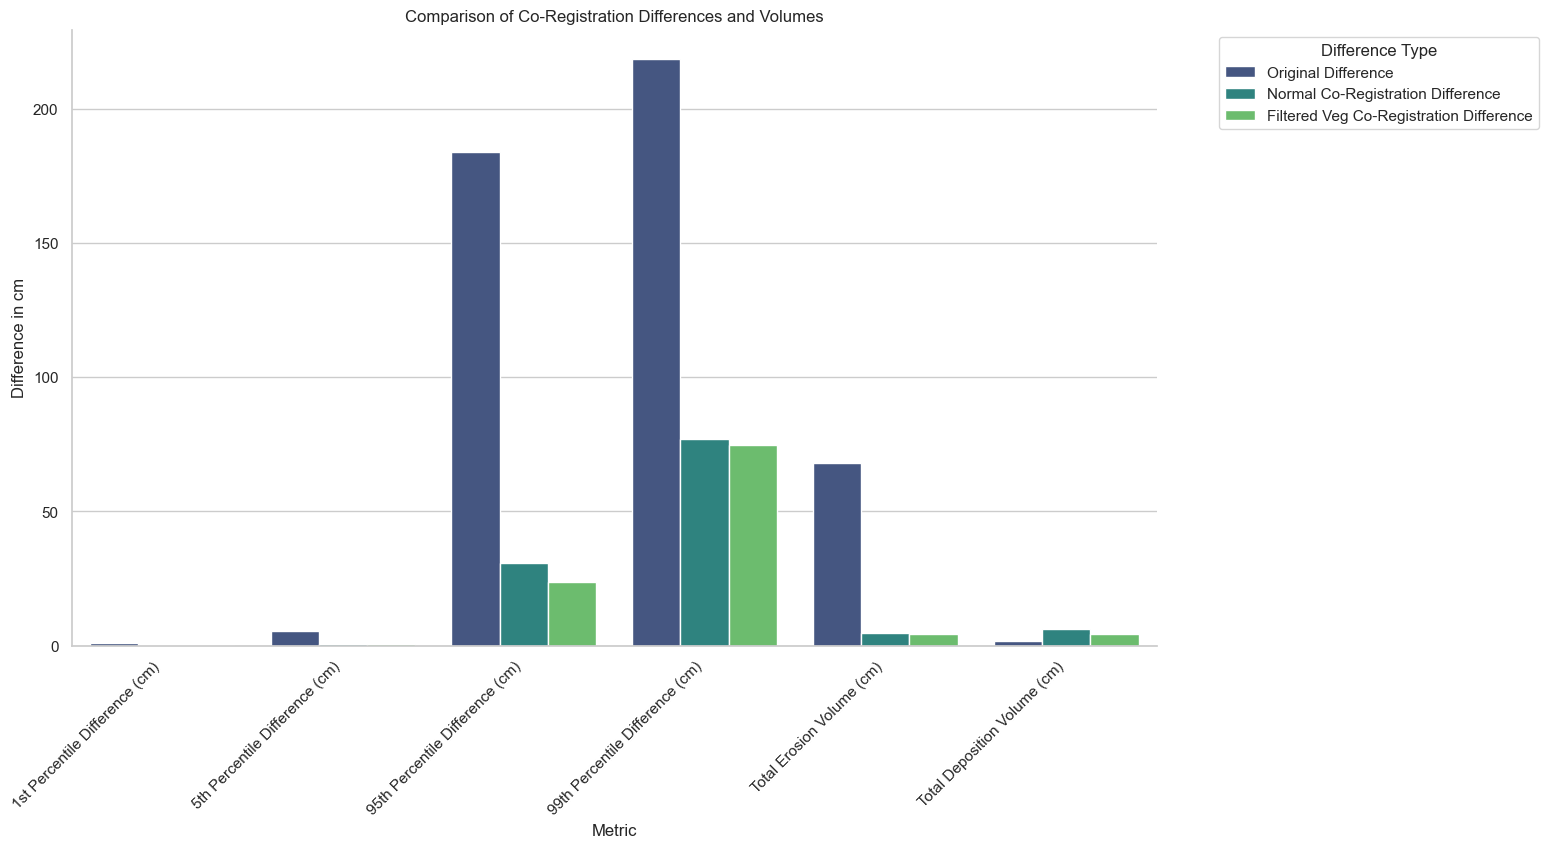

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data in a dictionary
data = {
    'Metric': ['1st Percentile Difference (cm)', '5th Percentile Difference (cm)', 
               '95th Percentile Difference (cm)', '99th Percentile Difference (cm)', 
               'Total Erosion Volume (cm)', 'Total Deposition Volume (cm)'],
    'Original Difference': [1.1, 5.3, 183.8, 218.5, 68.0, 1.7],
    'Normal Co-Registration Difference': [0.1, 0.6, 30.7, 76.9, 4.7, 6.1],
    'Filtered Veg Co-Registration Difference': [0.1, 0.5, 23.9, 74.8, 4.5, 4.5]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format
df_long = df.melt(id_vars='Metric', var_name='Registration Type', value_name='Difference (cm)')

# Set the plot style and color palette using seaborn
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=3)  # Using viridis palette for aesthetics

# Create the bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_long, x='Metric', y='Difference (cm)', hue='Registration Type', palette=palette)

# Customize the plot
plt.title('Comparison of Co-Registration Differences and Volumes')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Difference in cm')
plt.legend(title='Difference Type', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()  # Remove the top and right spines for a cleaner look

plt.show()


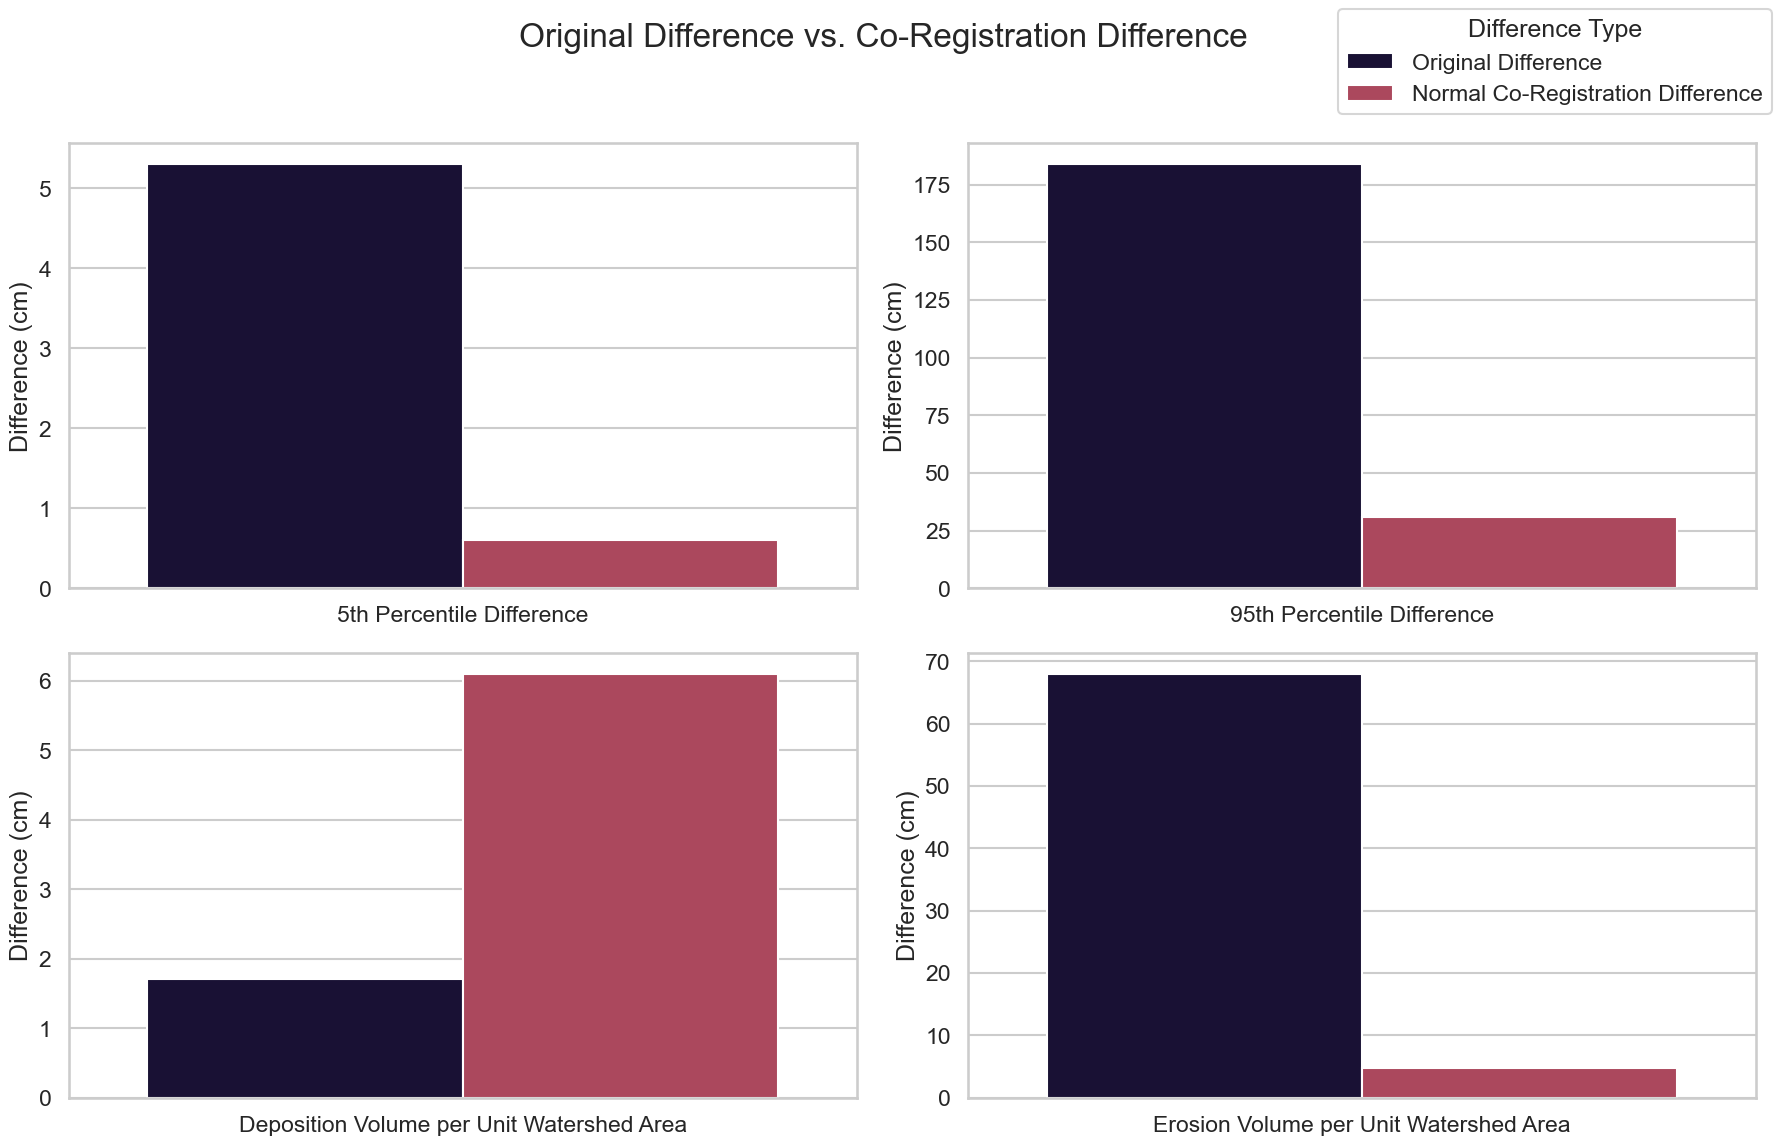

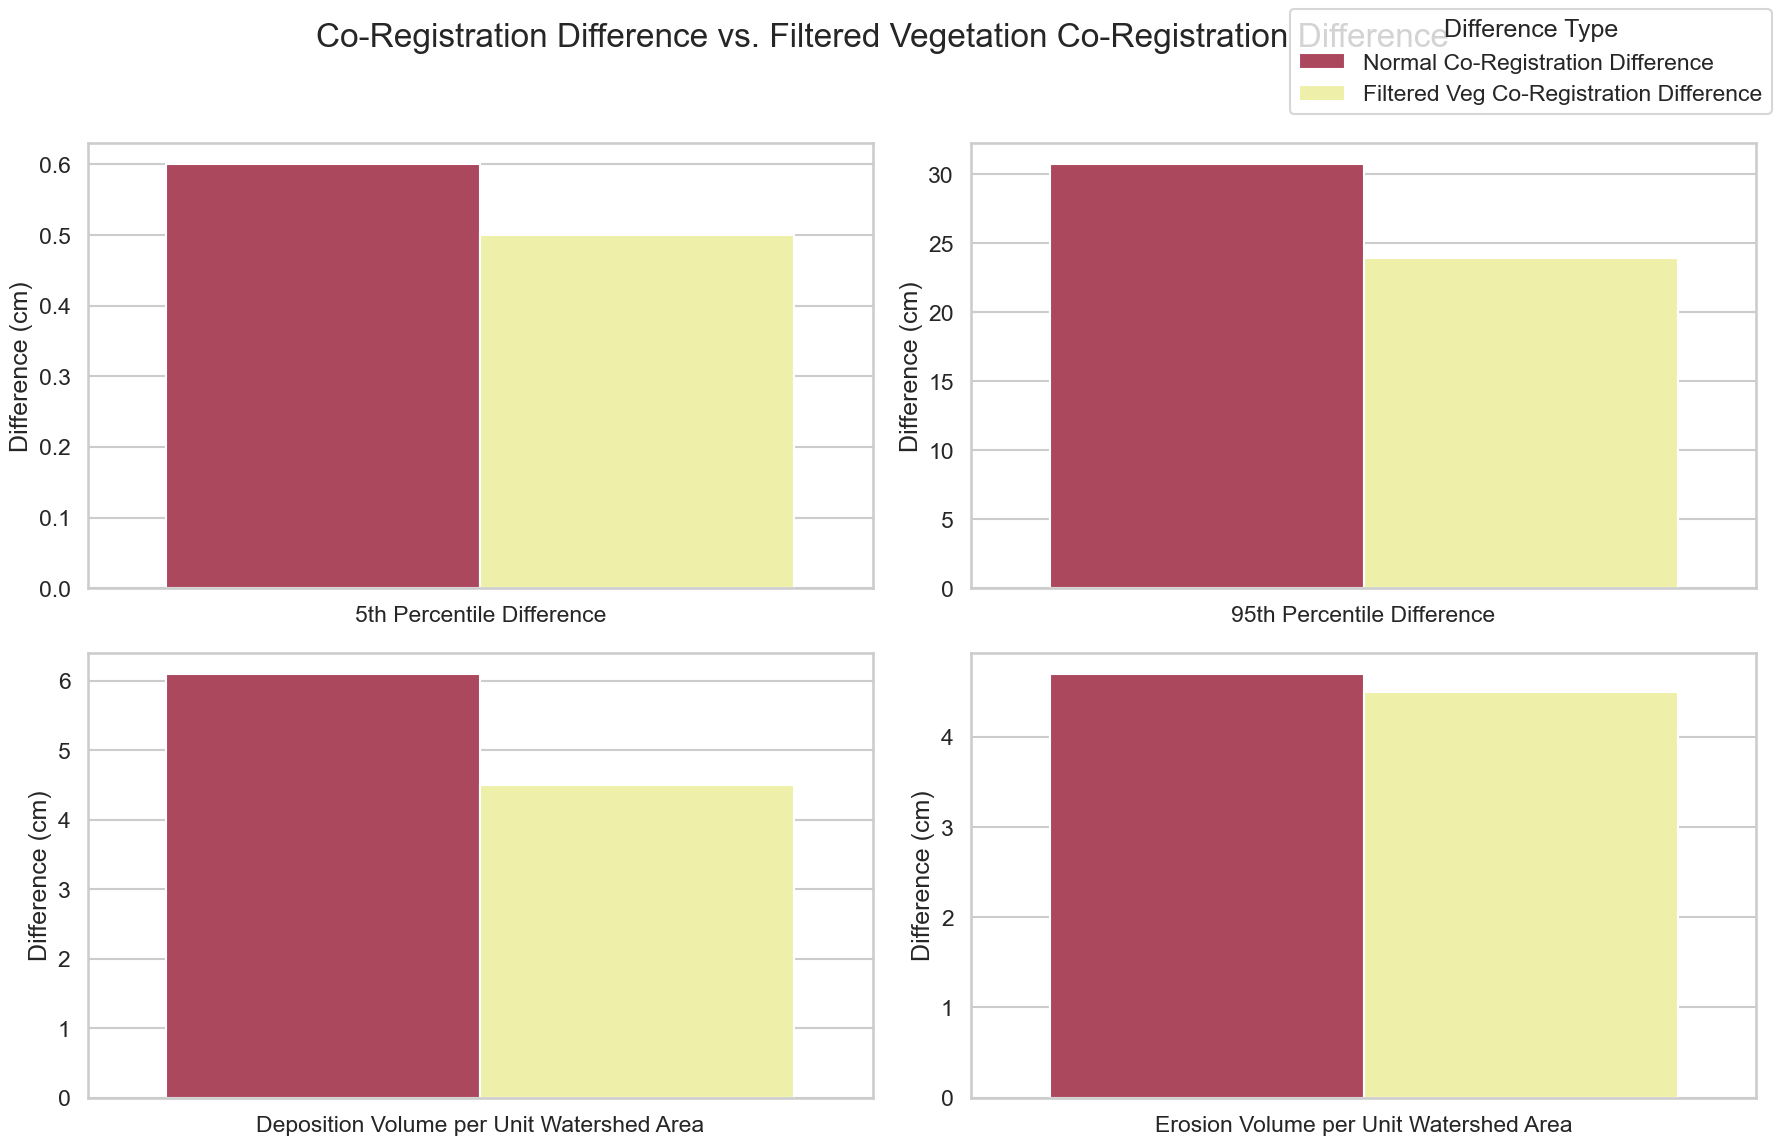

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
data = {
    'Metric': [
        '5th Percentile Difference', 
        '95th Percentile Difference', 
        'Erosion Volume per Unit Watershed Area', 'Deposition Volume per Unit Watershed Area'
    ],
    'Original Difference': [5.3, 183.8, 68.0, 1.7],
    'Normal Co-Registration Difference': [0.6, 30.7,4.7, 6.1],
    'Filtered Veg Co-Registration Difference': [0.5, 23.9, 4.5, 4.5]
}

# Convert dictionary to DataFrame and then melt it
df = pd.DataFrame(data)
df_long = df.melt(id_vars='Metric', var_name='Registration Type', value_name='Difference (cm)')

# Set seaborn style
sns.set(style="whitegrid")

# Generate a colormap
cmap = plt.cm.inferno

# Define a consistent color palette for the registration types
palette = {
    'Original Difference': cmap(0.1),
    'Normal Co-Registration Difference': cmap(0.5),
    'Filtered Veg Co-Registration Difference': cmap(0.99)
}

sns.set_context("talk")  # 'talk' is a predefined context suitable for presentations

# Function to create plots
def create_plots(data, title, fig_num):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))  # Adjust subplot grid and figure size
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Define custom order for metrics to control subplot placement
    custom_order = [
        '5th Percentile Difference', '95th Percentile Difference', 
         'Erosion Volume per Unit Watershed Area', 'Deposition Volume per Unit Watershed Area'
    ]

    # Group data by Metric with a specified order
    group_data = data.set_index('Metric').loc[custom_order].reset_index()
    
    for ax, (metric, group) in zip(axes, group_data.groupby('Metric')):
        sns.barplot(data=group, x='Metric', y='Difference (cm)', hue='Registration Type', ax=ax, palette=palette)
        ax.set_ylabel('Difference (cm)')
        ax.set_xlabel('')
        ax.get_legend().remove()  # Remove individual legends

    # Add a single legend for the whole figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Difference Type', loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    plt.suptitle(title, fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap, leaving space for the title
    plt.savefig(f"plot_group_{fig_num}.png")  # Save each figure as a PNG file
    plt.show()

# Group data for comparison
group1_data = df_long[df_long['Registration Type'].isin(['Original Difference', 'Normal Co-Registration Difference'])]
group2_data = df_long[df_long['Registration Type'].isin(['Normal Co-Registration Difference', 'Filtered Veg Co-Registration Difference'])]

# Create plots for each group
create_plots(group1_data, 'Original Difference vs. Co-Registration Difference', 1)
create_plots(group2_data, 'Co-Registration Difference vs. Filtered Vegetation Co-Registration Difference', 2)
